In [1]:
!nvidia-smi

Mon Jul 24 15:07:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from keras.models import load_model
my_modeld = load_model('/content/drive/MyDrive/archive (11)/pf3new_newbrats_3d.hdf5',compile=False)

In [5]:
import os
import numpy as np
#import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random

In [6]:
! pip install plotly scikit-image

1/1 [==============================] - 6s 6s/step


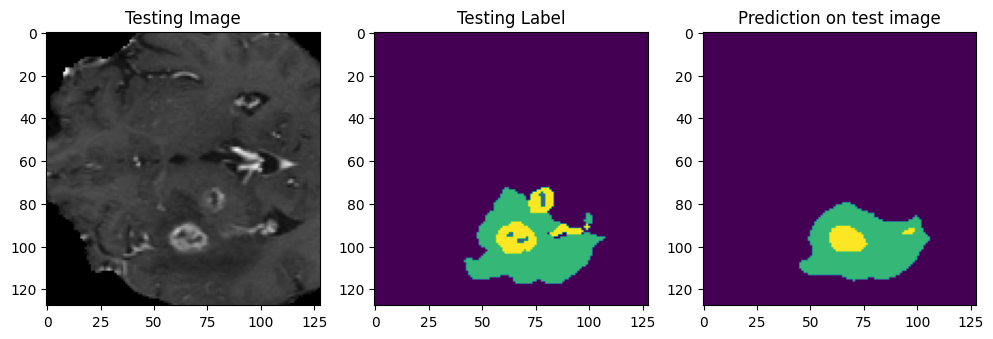

In [ ]:
img_num = 100


test_img = np.load("/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_modeld.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))


#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

In [ ]:
import numpy as np
import plotly.graph_objects as go
from skimage.measure import marching_cubes
from scipy.ndimage import label

img_num = 100
test_img = np.load("/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/input_data_128/val/images/image_"+str(img_num)+".npy")
test_mask = np.load("/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax = np.argmax(test_mask, axis=3)
test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_modeld.predict(test_img_input)
test_prediction_argmax = np.argmax(test_prediction, axis=4)[0]
voxel_volume =0.1
# Calculate the volume of the tumor
tumor_volume = np.sum(test_prediction_argmax == 1) * voxel_volume

# Create 3D surface plots of the original mask and predicted mask
def create_surface_plot(mask):
    vertices, faces, _, _ = marching_cubes(mask, level=0.5)
    x, y, z = vertices.T
    i, j, k = faces.T
    mesh = go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, opacity=0.5)
    return mesh

original_mask_surface = create_surface_plot(test_mask_argmax)
predicted_mask_surface = create_surface_plot(test_prediction_argmax)

# Create a figure and add the surfaces to it
fig = go.Figure(data=[original_mask_surface, predicted_mask_surface])

# Set the layout for the 3D graph
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis',
    ),
    title='Original Mask and Predicted Mask 3D Surface Plots',
)

# Show the 3D graph
fig.show()

print(f"Volume of the tumor: {tumor_volume:.2f} cubic units")


1/1 [==============================] - 7s 7s/step


Volume of the tumor: 286.80 cubic units


In [ ]:
import numpy as np
import plotly.graph_objs as go
from skimage.measure import marching_cubes

# Replace 'test_prediction_argmax' with your predicted 3D mask
predicted_mask = test_prediction_argmax == 1

# Use marching cubes algorithm to extract the surface vertices and faces
vertices, faces, _, _ = marching_cubes(predicted_mask, level=0.5)

# Create the 3D surface plot for the predicted mask
trace = go.Mesh3d(
    x=vertices[:, 0],
    y=vertices[:, 1],
    z=vertices[:, 2],
    i=faces[:, 0],
    j=faces[:, 1],
    k=faces[:, 2],
    opacity=0.5,  # Adjust the opacity of the surface plot
    color='rgba(255, 0, 0, 0.5)',  # Specify the color of the surface plot
)

# Set the layout for the 3D graph
layout = go.Layout(
    scene=dict(
        xaxis=dict(title='X Axis'),
        yaxis=dict(title='Y Axis'),
        zaxis=dict(title='Z Axis'),
    )
)

# Create the figure and add the trace to it
fig = go.Figure(data=[trace], layout=layout)

# Show the 3D graph
fig.show(figsize=(5, 8))

voxel_volume =0.1
# Calculate the volume of the tumor
tumor_volume = np.sum(test_prediction_argmax == 1) * voxel_volume
print(tumor_volume)


286.8


In [ ]:
import cv2
import numpy as np

# Load the 2D image (replace 'your_image_path.jpg' with the actual image path)
image_path = '/content/Hirnmetastase_MRT-T1_KM.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale

# Resize the 2D image to 128x128
resized_image = cv2.resize(image, (128, 128))

# Stack the resized 2D image along the depth axis to create a 3D volume
depth = 128
image_3d = np.stack([resized_image] * depth, axis=-1)

# Display the 3D image shape
print(image_3d.shape)  # Output: (128, 128, 128)

# Now image_3d is a 3D NumPy array representing the same image repeated across the depth axis.


(128, 128, 128)


In [ ]:
 temp_combined_images = np.stack((image_3d,)*3, axis=-1)

In [ ]:
test_img=temp_combined_images

In [ ]:
test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_modeld.predict(test_img_input)
test_prediction_argmax = np.argmax(test_prediction, axis=4)[0]
voxel_volume =0.1
# Calculate the volume of the tumor
tumor_volume = np.sum(test_prediction_argmax == 1) * voxel_volume

# Create 3D surface plots of the original mask and predicted mask
def create_surface_plot(mask):
    vertices, faces, _, _ = marching_cubes(mask, level=0.5)
    x, y, z = vertices.T
    i, j, k = faces.T
    mesh = go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, opacity=0.5)
    return mesh

# original_mask_surface = create_surface_plot(test_mask_argmax)
predicted_mask_surface = create_surface_plot(test_prediction_argmax)

# Create a figure and add the surfaces to it
fig = go.Figure(data=[predicted_mask_surface])

# Set the layout for the 3D graph
fig.update_layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis',
    ),
    title=' Predicted Mask 3D Surface Plots',
)

# Show the 3D graph
fig.show()

print(f"Volume of the tumor: {tumor_volume:.2f} cubic units")


1/1 [==============================] - 7s 7s/step


Volume of the tumor: 272.40 cubic units


1/1 [==============================] - 0s 122ms/step


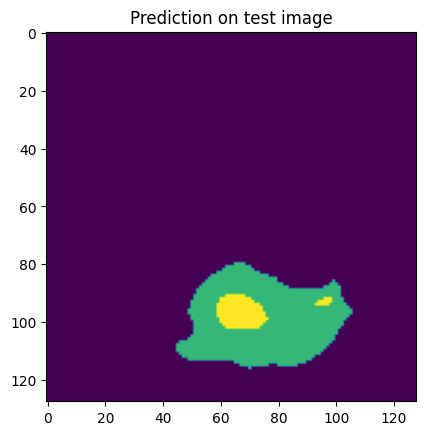

<Figure size 500x500 with 0 Axes>

In [56]:
img_num = 100


test_img = np.load("/content/drive/MyDrive/archive (11)/BraTS2020_TrainingData/input_data_128/val/images/image_"+str(img_num)+".npy")


test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_modeld.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55


plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.figure(figsize=(5, 5))
plt.show()

In [57]:
from re import A
import numpy as np

# Load the predicted mask with multiple colors
predicted_mask = test_prediction_argmax[:, :, n_slice]

# Define the pixel size
pixel_size = 0.1  # Replace with the actual pixel size or scale of your image

# Get the unique values in the grayscale mask (excluding the background value)
unique_values = np.unique(predicted_mask)

# Initialize a dictionary to store the area for each segment
segment_areas = {}

# Loop through each unique segment value (excluding the background value)
for segment_value in unique_values:
    # Create a binary mask for the current segment
    binary_mask = (predicted_mask == segment_value).astype(np.uint8)

    # Count the number of pixels for the current segment
    pixels_count = np.sum(binary_mask)

    # Calculate the area for the current segment
    area = pixels_count * pixel_size * pixel_size

    # Store the area in the dictionary with the segment value as the key
    segment_areas[segment_value] = area

# Calculate the total area for all segments
total_area = sum(segment_areas.values())

# Print the areas for each segment and the total area
for segment_value, area in segment_areas.items():
    print("Area of segmented part with value", segment_value, ":", area, "units squared")

print("Total area for all segmented parts:", total_area, "units squared")


for segment_value, area in segment_areas.items():
  seg=total_area-area
  break
print (seg)

s = round(seg)
if s in range(0,8):
  print('stage1')
elif s in range(8,14):
  print('stage2')
elif s in range(14,21):
  print('stage3')
else:
  print('stage4')

Area of segmented part with value 0 : 148.73000000000002 units squared
Area of segmented part with value 2 : 13.280000000000001 units squared
Area of segmented part with value 3 : 1.83 units squared
Total area for all segmented parts: 163.84000000000003 units squared
15.110000000000014
stage3


Some conditions are set to display the stages as per medical
field. The conditions are as follow:
1. If the tumor area is between 0 to 7 mm then it is
First stage and the it displays First stage comment
in identified stage block as shown in fig.
2. If the tumor is between 7 to 14 mm then the tumor
is at second stage.
3. If the tumor is between 14 to 21 mm then the tumor
is at third stage.
4. If the tumor is 21 and above then the tumor is in
critical stage.

In this way proper size and stage is detected and it helps to
doctor to provide a proper treatment or medicines as per
patient situation